In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Pmf
import Cdf
import glob

params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 10, 'ytick.labelsize' : 12}
plt.rcParams.update(params)


In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/ripe-agg.db')
df = pd.read_sql('select * from traceroute_as', con=conn, parse_dates=['timestamp'])
conn.close()


In [3]:
conn = sqlite3.connect('../data/tr-local-resolvers.db')
local_df = pd.read_sql('select * from "traceroute-as-paths" where centralized_resolver != 1', con=conn, parse_dates=['timestamp'])
conn.close()

In [4]:
df_v4 = df[df['addr_fam'] == 4]
df_v6 = df[df['addr_fam'] == 6]

In [5]:
local_v4 = local_df[local_df['addr_fam'] == 4]
local_v6 = local_df[local_df['addr_fam'] == 6]

In [6]:
local_v4

,msm_id,timestamp,method,probe_id,country,continent,centralized_resolver,is_probe_resolver,resolver_asn,resolver_holder,...,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,as_hop
1,27950923.0,2020-11-03 14:41:50,icmp-traceroute,28055.0,GR,EU,0,1,6799.0,OTENET-GR - Ote SA (Hellenic Telecommunication...,...,62.103.176.237,192.168.1.66,212.205.212.205,212.205.212.205,OK,5.0,5.0,212.205.212.205,14.618,1.0
3,27950556.0,2020-11-03 14:38:20,icmp-traceroute,54154.0,NL,EU,0,1,35224.0,PLINQ - PLINQ BV,...,185.9.253.216,192.168.2.124,193.239.186.141,193.239.186.141,OK,4.0,4.0,193.239.186.141,4.526,1.0
4,27950557.0,2020-11-03 14:38:20,icmp-traceroute,54154.0,NL,EU,0,1,35224.0,PLINQ - PLINQ BV,...,185.9.253.216,192.168.2.124,193.239.186.67,193.239.186.67,OK,4.0,4.0,193.239.186.67,4.554,1.0
5,27950449.0,2020-11-03 14:37:20,icmp-traceroute,12419.0,NZ,OC,0,1,134220.0,UFONE-AS-AP UFONE,...,45.118.188.167,10.108.1.119,103.58.228.2,103.58.228.2,OK,7.0,7.0,103.58.228.2,1.682,1.0
6,27950450.0,2020-11-03 14:37:20,icmp-traceroute,12419.0,NZ,OC,0,1,134220.0,UFONE-AS-AP UFONE,...,45.118.188.167,10.108.1.119,103.58.229.2,103.58.229.2,OK,6.0,6.0,103.58.229.2,2.101,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,27951534.0,2020-11-03 14:47:29,icmp-traceroute,31518.0,PL,EU,0,1,197979.0,INTERKAR-AS - INTERKAR KOMPUTER - SERWIS Karol...,...,91.231.25.217,10.9.217.246,91.231.24.4,91.231.24.4,OK,2.0,2.0,91.231.24.4,2.749,1.0
817,27951537.0,2020-11-03 14:47:33,icmp-traceroute,53805.0,NO,EU,0,1,29695.0,ALTIBOX_AS - Altibox AS,...,51.174.100.89,192.168.1.43,92.220.228.70,92.220.228.70,OK,6.0,6.0,92.220.228.70,1.672,1.0
818,27951538.0,2020-11-03 14:47:33,icmp-traceroute,16226.0,BG,EU,0,1,48747.0,LUKOVITNET - Lukovitnet Ltd.,...,94.139.206.182,192.168.88.254,94.139.204.1,94.139.204.1,OK,2.0,2.0,94.139.204.1,0.755,1.0
819,27951539.0,2020-11-03 14:47:34,icmp-traceroute,16226.0,BG,EU,0,1,48747.0,LUKOVITNET - Lukovitnet Ltd.,...,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3.0,3.0,94.139.204.10,1.584,1.0


In [7]:
df_v4.resolver_name.unique()

array(['Cloudflare', 'Quad9', 'CleanBrowsing', 'Neustar UltraRecursive',
       'VeriSign', 'Yandex', 'Google', 'OpenDNS', 'OpenNIC', 'NextDNS'],
      dtype=object)

In [8]:
v4_cdfs = dict()
v6_cdfs = dict()

v4_samples = dict()
v6_samples = dict()

for resolver in ['CleanBrowsing',
                 'Cloudflare',
                 'Google',
                 'OpenDNS',
                 'OpenNIC',
                 'Quad9',
                 'VeriSign',
                 'Yandex', 'NextDNS', 'Neustar UltraRecursive']:
    tmp_v4 = df_v4[df_v4['resolver_name'] == resolver]
    tmp_v6 = df_v6[df_v6['resolver_name'] == resolver]

    v4_samples[resolver] = len(tmp_v4)
    v6_samples[resolver] = len(tmp_v6)
    
    v4_cdfs[resolver] = Cdf.MakeCdfFromList(tmp_v4['as_hop'])
    v6_cdfs[resolver] = Cdf.MakeCdfFromList(tmp_v6['as_hop'])
    
v4_cdfs['local'] = Cdf.MakeCdfFromList(local_v4[local_v4['centralized_resolver'] == False]['as_hop'])
v6_cdfs['local'] = Cdf.MakeCdfFromList(local_v6[local_v6['centralized_resolver'] == False]['as_hop'])

v4_samples['local'] = len(local_v4[local_v4['centralized_resolver'] == False])
v6_samples['local'] = len(local_v6[local_v6['centralized_resolver'] == False])
    

In [9]:
probe_data = pd.read_json('../metadata/probe_v4_list.json')
probe_data6 = pd.read_json('../metadata/probe_v6_list.json')
probe_data = pd.concat([probe_data, probe_data6], ignore_index=True).drop_duplicates(subset='id')

In [10]:
probe_data

,address_v4,address_v6,asn_v4,asn_v6,country_code,description,first_connected,geometry,id,is_anchor,is_public,last_connected,prefix_v4,prefix_v6,status,status_since,tags,total_uptime,type
0,82.95.114.207,2001:983:ba7e:1:fad1:11ff:fea9:f090,3265.0,3265.0,NL,None,1359734868,"{'type': 'Point', 'coordinates': [4.9275, 52.3...",10001,False,True,1600187974,82.92.0.0/14,2001:980::/30,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1600076357,"[{'name': 'DSL', 'slug': 'dsl'}, {'name': 'Hom...",217842230,Probe
1,80.5.131.205,None,5089.0,NaN,GB,"Cambridge, UK (Mark III)",1359981047,"{'type': 'Point', 'coordinates': [0.1575, 52.2...",10006,False,True,1600187974,80.5.0.0/16,None,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1594146062,"[{'name': 'DSL', 'slug': 'dsl'}, {'name': 'Hom...",222203749,Probe
2,185.238.131.3,2a10:3781:516:1:fad1:11ff:fea9:ecbe,206238.0,206238.0,NL,Romeo - Home2,1360793290,"{'type': 'Point', 'coordinates': [5.2175, 52.3...",10015,False,True,1600187974,185.238.128.0/22,2a10:3780::/29,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1600077092,"[{'name': 'Fibre', 'slug': 'fibre'}, {'name': ...",234052366,Probe
3,83.68.21.139,2001:984:aee9:6:fad1:11ff:fea0:2b2e,3265.0,3265.0,NL,v3@dfk xs4all 500/500Mbit/s FTTH,1363611835,"{'type': 'Point', 'coordinates': [6.0385, 51.2...",10022,False,True,1600187974,83.68.16.0/21,2001:980::/29,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1600076195,"[{'name': 'Fibre', 'slug': 'fibre'}, {'name': ...",234229655,Probe
4,82.217.84.104,None,33915.0,NaN,NL,rvdm's probe,1363813215,"{'type': 'Point', 'coordinates': [5.1195, 52.0...",10046,False,True,1600187974,82.217.0.0/17,None,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1598078853,"[{'name': 'system: IPv4 Stable 90d', 'slug': '...",78365777,Probe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,None,2a02:8010:62f1:101:c225:e9ff:fea8:4d38,NaN,13037.0,GB,Glendon SMARTY WAN,1513634393,"{'type': 'Point', 'coordinates': [-2.5105, 52....",34945,False,True,1600188018,None,2a02:8010::/29,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1599281606,"[{'name': 'system: IPv6 Stable 1d', 'slug': 's...",33621889,Probe
3365,None,2a05:5800:4c3:3210:1:aaff:fefa:5e58,NaN,200924.0,DE,,1590953020,"{'type': 'Point', 'coordinates': [7.6995000000...",51155,False,True,1600188019,None,2a05:5800:400::/40,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1600119923,"[{'name': 'system: V4', 'slug': 'system-v4'}, ...",9191928,Probe
3409,None,2001:f40:904:459b:1:dbff:fec0:b631,NaN,9930.0,MY,iZND SOHO - TIME,1578566673,"{'type': 'Point', 'coordinates': [101.5715, 3....",52581,False,True,1600188019,None,2001:f40::/32,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1600022252,"[{'name': 'system: IPv6 Stable 90d', 'slug': '...",21395993,Probe
3414,None,2001:df0:8500:a210:1:b8ff:fedc:98a,NaN,59128.0,JP,,1593458288,"{'type': 'Point', 'coordinates': [139.7485, 35...",52633,False,True,1600188019,None,2001:df0:8500::/48,"{'id': 1, 'name': 'Connected', 'since': '2020-...",1598079011,"[{'name': 'system: IPv6 Capable', 'slug': 'sys...",6728414,Probe


In [11]:
outside_v4 = local_v4[(local_v4['as_hop'] > 1)]
outside_v6 = local_v6[(local_v6['as_hop'] > 1)]

In [12]:
outside_v4 = outside_v4.merge(probe_data, left_on='probe_id', right_on='id', how='left')

In [13]:
outside_v6 = outside_v6.merge(probe_data, left_on='probe_id', right_on='id', how='left')

In [14]:
pd.crosstab(outside_v4['resolver_holder'],outside_v4['asn_v4'])

asn_v4,3265.0,3320.0,4764.0,5089.0,6327.0,6799.0,6830.0,7018.0,7545.0,7922.0,...,34362.0,34779.0,38195.0,39544.0,40788.0,42560.0,44257.0,46375.0,206238.0,328137.0
resolver_holder,,,,,,,,,,,,,,,,,,,,,
ACCELERATED-IT - Accelerated IT Services & Consulting GmbH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALISTAIR-MACKENZIE - Alistair Mackenzie,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARNES-NET - ARNES,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
"ASN-ASIPN - PJSC ""Industrial Media Network""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATT-INTERNET4,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
BAHNHOF - Bahnhof AB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COGENT-174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"CZNIC-AS3 - CZ.NIC, z.s.p.o.",0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DETEQUE,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
pd.crosstab(outside_v6['resolver_holder'],outside_v6['asn_v6'])

asn_v6,209.0,812.0,2119.0,3215.0,6830.0,6939.0,12322.0,12897.0,13030.0,13037.0,20712.0,31246.0,33657.0,33915.0,35540.0,132383.0,206238.0,208261.0
resolver_holder,,,,,,,,,,,,,,,,,,
ALARIG - Groupe Rennais pour un Internet Fourni de maniere Ouverte et Neutre,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BAHNHOF - Bahnhof AB,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
CENTURYLINK-EUROPE-LEGACY-QWEST,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"CZNIC-AS3 - CZ.NIC, z.s.p.o.",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
DTAG - Deutsche Telekom AG,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
EXN-AS - EX Networks Limited,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"GITOYEN-MAIN-AS - Association ""Gitoyen""",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
HURRICANE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
LDN - Lorraine Data Network,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
local_v4[(local_v4['as_hop'] > 1)]['resolver_holder']

8                                LDCOMNET - SFR SA
28                                      COGENT-174
31                HETZNER-AS - Hetzner Online GmbH
44                                        ULTRADNS
45                                        ULTRADNS
                          ...                     
789    ASN-ASIPN - PJSC "Industrial Media Network"
800                                NL-BIT - BIT BV
801                                NL-BIT - BIT BV
802            LIBERTYGLOBAL - Liberty Global B.V.
803            LIBERTYGLOBAL - Liberty Global B.V.
Name: resolver_holder, Length: 74, dtype: object

In [17]:
for k in v4_cdfs.keys():
    print(k)
    for l in list(zip(v4_cdfs[k].xs, v4_cdfs[k].ps)):
        print(l)
    print('=================')

CleanBrowsing
(1.0, 0.02943189596167009)
(2.0, 0.31759069130732376)
(3.0, 0.813141683778234)
(4.0, 0.971937029431896)
(5.0, 0.999315537303217)
(6.0, 1.0)
Cloudflare
(1.0, 0.0725758477096966)
(2.0, 0.5728732897085068)
(3.0, 0.9399167162403331)
(4.0, 0.9863176680547293)
(5.0, 0.9994051160023796)
(6.0, 1.0)
Google
(1.0, 0.04242424242424243)
(2.0, 0.8036363636363636)
(3.0, 0.9824242424242424)
(4.0, 0.9975757575757576)
(5.0, 0.9993939393939394)
(6.0, 1.0)
OpenDNS
(1.0, 0.031756318859364877)
(2.0, 0.35515230071289694)
(3.0, 0.8016850291639663)
(4.0, 0.9766688269604666)
(5.0, 0.9993519118600129)
(6.0, 1.0)
OpenNIC
(1.0, 0.03211351755041075)
(2.0, 0.2949962658700523)
(3.0, 0.7998506348020911)
(4.0, 0.9671396564600448)
(5.0, 0.9992531740104555)
(6.0, 1.0)
Quad9
(1.0, 0.04732080723729993)
(2.0, 0.6416144745998609)
(3.0, 0.9269311064718163)
(4.0, 0.9965205288796103)
(5.0, 0.9993041057759221)
(6.0, 1.0)
VeriSign
(1.0, 0.03428571428571429)
(2.0, 0.16444444444444445)
(3.0, 0.593015873015873)
(4.0, 0

In [18]:
for k in v6_cdfs.keys():
    print(k)
    for l in list(zip(v6_cdfs[k].xs, v6_cdfs[k].ps)):
        print(l)
    print('=================')

CleanBrowsing
(2.0, 0.1488095238095238)
(3.0, 0.5372023809523809)
(4.0, 0.9330357142857143)
(5.0, 0.9955357142857143)
(6.0, 1.0)
Cloudflare
(1.0, 0.006952491309385863)
(2.0, 0.522595596755504)
(3.0, 0.9524913093858632)
(4.0, 0.9907300115874855)
(5.0, 1.0)
Google
(1.0, 0.0033444816053511705)
(2.0, 0.8584169453734671)
(3.0, 0.9821627647714605)
(4.0, 0.9988851727982163)
(5.0, 1.0)
OpenDNS
(1.0, 0.0035629453681710215)
(2.0, 0.44536817102137766)
(3.0, 0.8693586698337292)
(4.0, 0.9869358669833729)
(5.0, 1.0)
OpenNIC
(2.0, 0.16167664670658682)
(3.0, 0.49700598802395207)
(4.0, 0.8323353293413174)
(5.0, 0.9940119760479041)
(6.0, 1.0)
Quad9
(1.0, 0.00228310502283105)
(2.0, 0.5171232876712328)
(3.0, 0.9394977168949772)
(4.0, 0.9931506849315068)
(5.0, 1.0)
VeriSign
(2.0, 0.25177304964539005)
(3.0, 0.74822695035461)
(4.0, 0.9645390070921985)
(5.0, 0.991725768321513)
(6.0, 1.0)
Yandex
(1.0, 0.0025806451612903226)
(2.0, 0.28516129032258064)
(3.0, 0.8490322580645161)
(4.0, 0.9896774193548387)
(5.0, 0.

In [19]:
colors = {'CleanBrowsing': 'C0',
          'Cloudflare': 'C1',
          'Google': 'C2',
          'Neustar UltraRecursive': 'C3',
          'OpenDNS': 'C4',
          'OpenNIC': 'C5',
          'Quad9': 'C6',
          'VeriSign': 'C7',
          'Yandex': 'C8',
          'local': 'C9',
          'NextDNS': '#009E73'
         }

In [20]:
markers = {'CleanBrowsing': 'o',
          'Cloudflare': 'v',
          'Google': '^',
          'Neustar UltraRecursive': '<',
          'OpenDNS': '>',
          'OpenNIC': 's',
          'Quad9': 'p',
          'VeriSign': 'h',
          'Yandex': 'd',
          'local': '*',
           'NextDNS': '.'
         }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


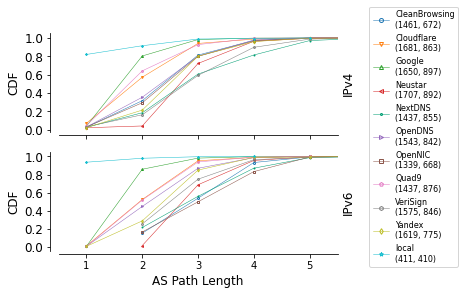

In [21]:
fig, (ax_v4, ax_v6) = plt.subplots(figsize=(5,4), nrows=2)

for (as_hop_cdf, ax, smples) in [(v4_cdfs, ax_v4, v4_samples), (v6_cdfs, ax_v6, v6_samples)]:
    
    for k in sorted(as_hop_cdf.keys()):
        
        ax.plot(as_hop_cdf[k].xs, as_hop_cdf[k].ps,
                label=k.split(' ')[0] + '\n(' +  str(v4_samples[k]) + ', ' + str(v6_samples[k]) + ')', color=colors[k],
                marker=markers[k], markersize=2, # markevery=max(1, len(ttl_cdf[k].xs)/50),
                linewidth=0.5, fillstyle='none')

        ax.set_yticks(np.arange(0, 1.1, 0.2))
#         ax.set_xscale('symlog')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.03))
        ax.spines['left'].set_position(('axes', -0.03))
        ax.set_xlim([0.5, 5.5])
#         ax.set_xticks(np.arange(0,8,1))
        

ax_v4.set_xlabel('')
ax_v6.set_xlabel('AS Path Length')

ax_v4.set_title('')
ax1_ = ax_v4.twinx()
ax1_.spines['right'].set_color('none')
ax1_.spines['top'].set_color('none')
ax1_.spines['left'].set_color('none')
ax1_.spines['bottom'].set_color('none')
ax1_.yaxis.set_ticks_position('none')
ax1_.set_ylabel('IPv4')
plt.setp(ax1_.get_yticklabels(), visible = False)

ax_v6.set_title('')
ax2_ = ax_v6.twinx()
ax2_.spines['right'].set_color('none')
ax2_.spines['top'].set_color('none')
ax2_.spines['left'].set_color('none')
ax2_.spines['bottom'].set_color('none')
ax2_.yaxis.set_ticks_position('none')
ax2_.set_ylabel('IPv6')
plt.setp(ax2_.get_yticklabels(), visible = False)

ax_v4.set_ylabel('CDF')
ax_v6.set_ylabel('CDF')

plt.setp(ax_v4.get_xticklabels(), visible = False)

# ax_v4.legend(loc = 'lower left', markerscale = 2, fontsize = 10, ncol=2, bbox_to_anchor=(-0.25,1.05))
ax_v4.legend(loc = 'lower left', markerscale = 2, fontsize = 8, ncol=1, bbox_to_anchor=(1.1,-1.4))
    
fig.savefig('../plots/as-paths-v4v6.pdf', bbox_inches='tight')
fig.savefig('../plots/as-paths-v4v6.eps', bbox_inches='tight')

In [22]:
for k in sorted(v4_cdfs.keys()):
    print(k)
    print(list(v4_cdfs[k].xs))
for k in sorted(v6_cdfs.keys()):
    print(k)
    print(list(v6_cdfs[k].xs))

CleanBrowsing
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Cloudflare
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Google
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Neustar UltraRecursive
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
NextDNS
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
OpenDNS
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
OpenNIC
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Quad9
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
VeriSign
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Yandex
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
local
[1.0, 2.0, 3.0, 4.0, 5.0]
CleanBrowsing
[2.0, 3.0, 4.0, 5.0, 6.0]
Cloudflare
[1.0, 2.0, 3.0, 4.0, 5.0]
Google
[1.0, 2.0, 3.0, 4.0, 5.0]
Neustar UltraRecursive
[2.0, 3.0, 4.0, 5.0, 6.0]
NextDNS
[2.0, 3.0, 4.0, 5.0, 6.0]
OpenDNS
[1.0, 2.0, 3.0, 4.0, 5.0]
OpenNIC
[2.0, 3.0, 4.0, 5.0, 6.0]
Quad9
[1.0, 2.0, 3.0, 4.0, 5.0]
VeriSign
[2.0, 3.0, 4.0, 5.0, 6.0]
Yandex
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
local
[1.0, 2.0, 3.0, 4.0]


In [23]:
v4_cdfs = dict()
v6_cdfs = dict()

for continent in ['EU', 'NA', 'OC', 'AS', 'SA', 'AF']:
    tmp_v4 = df_v4[df_v4['continent'] == continent]
    tmp_v6 = df_v6[df_v6['continent'] == continent]
    
    local_tmp_v4 = local_v4[local_v4['continent'] == continent] 
    local_tmp_v6 = local_v6[local_v6['continent'] == continent]
    
    v4_cdfs[continent] = Cdf.MakeCdfFromList(tmp_v4['as_hop'].append(local_tmp_v4['as_hop']))
    v6_cdfs[continent] = Cdf.MakeCdfFromList(tmp_v6['as_hop'].append(local_tmp_v6['as_hop']))
    

In [24]:
colors = {'AF': 'C0',
          'AS': 'C1',
          'EU': 'C2',
          'NA': 'C3',
          'OC': 'C4',
          'SA': 'C5',
         }

markers = {'AF': 'o',
           'AS': 'v',
           'EU': '^',
           'NA': '<',
           'OC': '>',
           'SA': 's',
         }

v4
AF
(1.0, 0.05844155844155844)
(2.0, 0.5454545454545454)
(3.0, 0.7662337662337663)
(4.0, 0.9545454545454546)
(5.0, 0.9935064935064936)
(6.0, 1.0)
v4
AS
(1.0, 0.025411061285500747)
(2.0, 0.31390134529147984)
(3.0, 0.6771300448430493)
(4.0, 0.9013452914798207)
(5.0, 0.9880418535127056)
(6.0, 1.0)
v4
EU
(1.0, 0.040877367896311065)
(2.0, 0.38058551617873654)
(3.0, 0.8176379951055923)
(4.0, 0.9553158705701078)
(5.0, 0.9943804948789994)
(6.0, 0.9996374512825161)
(7.0, 1.0)
v4
NA
(1.0, 0.11973918197984589)
(2.0, 0.3669235328986366)
(3.0, 0.8162418494368702)
(4.0, 0.973325429756965)
(5.0, 0.998221695317131)
(6.0, 0.9997036158861885)
(7.0, 1.0)
v4
OC
(1.0, 0.031578947368421054)
(2.0, 0.3873684210526316)
(3.0, 0.6905263157894737)
(4.0, 0.9010526315789473)
(5.0, 0.9894736842105263)
(6.0, 0.9978947368421053)
(7.0, 1.0)
v4
SA
(1.0, 0.05806451612903226)
(2.0, 0.18064516129032257)
(3.0, 0.6258064516129033)
(4.0, 0.9419354838709677)
(5.0, 1.0)
v6
AF
v6
AS
(1.0, 0.02702702702702703)
(2.0, 0.332432432

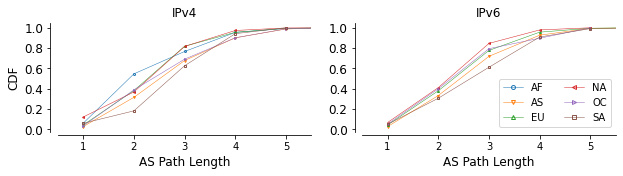

In [25]:
fig, (ax_v4, ax_v6) = plt.subplots(figsize=(10,2), ncols=2)

for (as_hop_cdf, ax) in [(v4_cdfs, ax_v4), (v6_cdfs, ax_v6)]:
    
    for k in sorted(as_hop_cdf.keys()):
        if ax == ax_v4:
            print('v4')
        else:
            print('v6')
        print(k)
        for l in list(zip(as_hop_cdf[k].xs, as_hop_cdf[k].ps)):
            print(l)
        
        ax.plot(as_hop_cdf[k].xs, as_hop_cdf[k].ps,
                label=k, color=colors[k],
                marker=markers[k], markersize=2, # markevery=max(1, len(ttl_cdf[k].xs)/10),
                linewidth=0.5, fillstyle='none')
        
        ax.set_yticks(np.arange(0, 1.1, 0.2))
#         ax.set_xscale('symlog')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.03))
        ax.spines['left'].set_position(('axes', -0.03))
        ax.set_xlim([0.5, 5.5])

        
ax_v4.set_xlabel('AS Path Length')
ax_v6.set_xlabel('AS Path Length')

ax_v4.set_title('IPv4')
ax_v6.set_title('IPv6')

ax_v4.set_ylabel('CDF')
ax_v6.set_ylabel('')

ax_v6.legend(loc = 'lower right', markerscale = 2, fontsize = 10, ncol=2)
    
fig.savefig('../plots/as-paths-continents.pdf', bbox_inches='tight')